# Multiprocessing tutorial
By Richard Petrie

## The goal of this tutorial
In this tutorial we will cover why we would want to use multi-processing to do data analytics. In class we've only worked on small data sets. A few hundred lines, maybe a couple megabytes. In this tutorial we will analyze a 4.3GB file containing more than 446 million passwords. We will face two major challenges

First, with large files we won't be able to fit the entire dataset into memory. While we technically could with this 4.3GB file, I hope to do similiar work on a 170GB file in the future. That file definitly would not fit in our machine's memory. We beat this by only reading a part of the file at a time.

Second, there is a lot of work to do. Every operation I want to perform on these words, like finding the most common letter, I have to do 446 million times. Since each password can be analyzed individually regardless of how the other passwords look, we can do multiple words at a time.

## What is multi processing?
In short, it's using multiple processes to do a single job. Here is a handy picture that does a good job representing what is happening.

![apprize](images/multiprocess.jpg)

As you can see, the child proceses are talking back to the main process who is the only one reading from the disk. This means we don't have multiple processes reading form the file (which is VERY hard), but we can put the child processes to work.

Without further ado, on to the code!

## The imports
We used Counter and csv in class, so I'm going to skip those two.

* time: We use this module to track how long our code takes to run, so we know how much faster it is to run concurrently.
* os: I developed this on both a Windows and Linux machine, this library makes it easier for me to switch between my machines.
* multiprocessing: This is the core 'magic' of the program. Python's built in module for opening child processes and communicating with them. The "Pool" object here is an easy way to create a 'resource pool'. The "Queue" object is used so the main process can communicate with the child processes
* multiprocessing.dummy: There is a bug on Windows that prevents the main multiprocessing library from working inside Jupyter. This library fixes that.
* queue: I import an error code here so I can know when we are done communicating with the child processes

In [1]:
import time
import csv
from collections import Counter, defaultdict
import os
if os.name == "nt":
    from multiprocessing.dummy import Pool, Queue
else:
    from multiprocessing import Pool, Queue
from queue import Empty

## Constants
We haven't done this in class, but I use some values multiple times throughout my entire program, and they never change. To make it easier, I keep all of those values up here.

In [2]:
# Constants.
# Change this to change program function

# The file with the passwords
if os.name == "nt":
    FILEPATH = "D:/password/no_null.csv"
else:
    FILEPATH = "/home/richardp/passwords/no_null.csv"

# Number of passwords to read from disk before passing to CPU
PER_ITER = 1000000

# Number of iterations to to run
ITER_MAX = 500
total_pass = PER_ITER * ITER_MAX
print(f"We will read up to {total_pass:,} passwords from {FILEPATH}")

# Process inter-communication
jobs = Queue(maxsize=6)
results = Queue()

We will read up to 500,000,000 passwords from /home/richardp/passwords/no_null.csv


## The first problem: Dealing with large datasets
Having a lot of data is both a good thing. It allows us to find more interesting facts about our data. For example, I could ask this dataset if the most common third character in a password was a number or letter. With only 100 passwords I don't have significant confidence in what my data is telling me. With nearly 450 million passwords I can make a pretty effective guess. 

However, it is also a burdan. It takes time to process all that data. For example, my test case has been a 4.3GB csv file that contains no columns, only a single password per line. When we attempt to load this into a pandas dataframe, pandas attempts to analyze it all at once and does so very ineffeciently. When I attempted this on my computer with 16 GB of RAM, pandas kept trying to analyze my 4.3GB file until it had taken up nearly 25 GB of memory, well more than my computer actually has. It didn't even finish, I had to kill the process.

![](images/pandas.PNG)

To solve this problem, we write something like this. This code is a special type of function called a generator. It allows us to read small pieces of the file, and analyze chunks of it at a time instead of all at once. This does prevent us from doing any type of correlation analysis directly on the data, as we will never have all of the data at once. In my case, this is fine. 

In [3]:
def read_passwords(per_iter=PER_ITER, iterations=ITER_MAX):
    with open(FILEPATH, newline='', encoding="latin1") as csvfile:
        reader = csv.reader(csvfile, delimiter='\n', quoting= csv.QUOTE_NONE)
        # This loop controls how many times you read from the file.
        # This is useful if you don't want to read the entire file.
        for _ in range(iterations):
            words = []
            # This loop controls how many passwords you read each time you loop over it.
            # Useful for controlling the amount of RAM in use.
            for _ in range(per_iter):
                try:
                    word = next(reader)
                    words.append(word)
                except StopIteration:
                    break
            yield words

## Not using pandas
The problem remains that Pandas is doing significantly more calculations than we need for our data. This means that in order to analyze our data we will be dealing with a lot of things we don't need, which we will call overhead. In this case, at least 20GB of data that was loaded we didn't need. This severely increases the time it takes to analyze large data sets. So we have decided to not use Pandas, and instead build our own analysis tools. The Data class below acts very similiar to a pandas DataFrame. 

In [4]:
class Data:
    # Similiar to how you might call pd.DataFrame() to create a DataFrame
    # you could call Data() to create this Data object.
    # __init__ is a special function that helps create the object
    def __init__(self, words=None):
        # This field will track the length of every password
        self.len_counter = Counter()
        # This value will equal the number of passwords we analyzed
        self.word_count = 0
        # This is useful for troubleshooting how many Data objects we created
        self.iterations = 1
        # this counts how often every character is used in all the passwords we read
        self.unique_chars = Counter()
        # This contains len: entropy combinations
        self.len_entropy = defaultdict(Counter)
        
        if words:
            self.calculate(words)
    
    # This function is called when you attempt to add Data to something else
    # In this case, it errors if that something else isn't also a Data object
    def __add__(self, other):
        if type(other) != Data:
            raise TypeError(f"Added {type(other)} to Data")
            
        # This is a small optimization to make things faster
        if self.word_count == 0:
            return other
        if other.word_count == 0:
            return self
        
        # This code actually does all of the addition
        self.word_count += other.word_count
        self.len_counter.update(other.len_counter)
        self.iterations += other.iterations
        self.unique_chars.update(other.unique_chars)
        for k in other.len_entropy.keys():
            self.len_entropy[k].update(other.len_entropy[k])

        return self
    
    # This is a special function that is called when you print() something
    def __repr__(self):
        return f"We found {self.word_count:,} passwords."
    
    # We use this function to populate our values with the data we read from the CSV
    def calculate(self, words):
        for word in words:
            w = str(word)
            self.len_counter[len(w)] += 1
            self.word_count += 1
            
            # This one line of code takes more time to run
            # then all the other code here combined.
            # It counts ever letter in a word, for all hundreds of millions of words
            self.unique_chars.update(w)
            
            self.len_entropy[len(w)][entropy(w)] += 1
            
            
    
    def get_num_chars(self):
        return sum(data.unique_chars.values())
    
def entropy(word):
    u = 0
    l = 0
    n = 0
    s = 0
    rs = 0
    o = 0
    for c in word:
        if c.isupper():
            u = 1
        elif c.islower():
            l = 1
        elif c.isdigit():
            n = 1
        elif c in '!@#$%^&*()':
            s = 1
        elif c in '`~-_=+,<.>/?;:\'"[{]}\\|])':
            rs = 1
        else:
            o = 1
    t = u+l+n+s+rs+o
    return int(t)
    

## The Fun Part: Multiprocessing
Multiprocessing is hard to explain. We are actually starting new python child processes to do our work for us. We are telling them to line up in front of a job board, and posting password lists to the board. They take the password list, do the calculations, and put the results in a different board. Then they get back in line for a new job. At the end, we collect all the results and combine them together.

To keep our test code below clean, we've also made an object just to schedule and run our jobs.

In [5]:
class JobHandler:
    # You start a job handler with the number of processes you want to spawn
    # so JobHandler(2) would start 2 child processes
    def __init__(self, cores):
        self.cores = cores
        # This code spawns a number of child processes and tells them to run the counter 
        # function when they start
        self.pool = Pool(cores, initializer=self.counter, initargs=(jobs, results))
        self.word_generator = word_generator
    
    # This is the main function that you would run to do all the work.
    def run(self,  word_generator):
        self._schedule(word_generator)
        return self._get_results()
    
    # We start a function with an underscore to indicate that you should not run it directly
    # These function are for the object to use, not for the user to call.
    # In this case, this function reads the data from the csvfile
    # and tells the child processes what to do. Afterwards, it cleans them all up
    def _schedule(self, word_generator):
        for df in word_generator:
            jobs.put(df)
        for _ in range(self.cores): #tell workers we're done
            jobs.put(None)
        self.pool.close()
        self.pool.join()

    def _get_results(self):
        data = Data()
        while True:
            try:
                data += results.get_nowait()
            except Empty:
                break
        return data
    
    # This is the function that the child processes will run in
    # It does all the actual work to analyze the data
    @staticmethod
    def counter(jobs, response):
        data = Data()
        while True:
            my_job = jobs.get()
            if my_job is not None:
                data += Data(my_job)
            else:
                response.put(data)
                break
            

## So wait, why did we do this again?

This code below opens our generator, and runs through the entire password file in a single process. This is the 'normal' version, with no special tricks. We still only read small chunks of the file at a time, but the same process reads from the file and does the calculations.

In [6]:
# Not threaded
word_generator = read_passwords()
data = Data()
start = time.perf_counter()
for words in word_generator:
    data += Data(words)
    
elapsed = time.perf_counter() - start
print(f"Done after {data.iterations} iterations. Took {elapsed} seconds")
print(data)
print(f"We counted {data.get_num_chars():,} characters in total!")

Done after 447 iterations. Took 4820.56538812 seconds
We found 446,312,451 passwords.
We counted 5,798,976,333 characters in total!


## Alright, so what's the big deal?

This code is the concurent one, which can both read from the file, and do the analysis at the same time. In fact, it does 4 sections of the CSV file all at the same time while the main process is the one reading from the file.

In [7]:
# Threaded
start = time.perf_counter()
data = JobHandler(4).run(read_passwords())
elapsed2 = time.perf_counter() - start
print(f"Done after {data.iterations} iterations. Took {elapsed2} seconds")
diff = (elapsed - elapsed2) / ((elapsed + elapsed2) / 2) * 100
print(f"Difference was {diff}%")
print(data)
print(f"We counted {data.get_num_chars():,} characters in total!")

Done after 447 iterations. Took 2640.2894240019996 seconds
Difference was 58.44574164814477%
We found 446,312,451 passwords.
We counted 5,798,976,333 characters in total!


## Oh hey, that was fast
Yep! Thanks to the fact that we can process multiple pieces of our data set at once, we see a speedup of around 50%. And you can see that it found the same number of passwords, and the same number of characters! This way we know the the process works, and it allows us to do our work so much faster! If this scales linerally, on my 170GB file I will save hours on every run.

## But what now?
Well, now you do the analysis as you usually would. Some interesting points of data to be considered:

1. How complex passwords are (shown below)
2. If passwords follow patterns (starting with an uppercase letter, ending with a number)
3. The most common characters in passwords
4. The most effecient way to guess passwords

## Analysis example
This pivot table shows the % of passwords of a given length that have an entropy value from 1 to 6. 1 being they only use the same kind of charcter (all lower case, all numbers, all symbols, etc). An entropy balue of 5 would mean they used 5 of the 6 types of chracters (numbers, lowercase letters, uppercase letters, etc)



In [8]:
import pandas as pd

f = {k:v for k,v in data.len_entropy.items() if k<21}
df = pd.DataFrame(f)
df = df.fillna(0)
cols = [2] + list(range(5,21))
df[cols] = df[cols].div(df[cols].sum(), axis=1).multiply(100)
print("Percent passwords with entropy by length")
df

Percent passwords with entropy by length


,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,100.0,14.553991,2.352266,0.025133,0.042411,0.127991,0.006170,0.000869,0.000519,0.000598,0.000298,0.000198,0.000537,0.000278,0.000403,0.000275,0.001069
2,0.0,85.446009,54.647160,15.320133,14.220808,31.789190,43.071934,50.456798,38.087109,26.834035,27.388925,31.123197,31.870742,32.985664,37.137596,69.364444,43.025514
3,0.0,0.000000,43.000574,66.877782,57.346704,64.315027,46.918363,42.246265,43.814263,53.309222,53.805171,51.803252,52.296671,50.369512,48.965522,24.049110,46.383308
4,0.0,0.000000,0.000000,17.776953,28.340200,2.416112,9.798579,6.789104,16.931331,18.399849,17.639589,15.578387,14.406258,15.250435,12.537705,5.910653,9.456844
5,0.0,0.000000,0.000000,0.000000,0.049876,1.231082,0.204206,0.504202,1.165253,1.453729,1.164319,1.490183,1.419818,1.387497,1.350584,0.667678,1.116540
6,0.0,0.000000,0.000000,0.000000,0.000000,0.120598,0.000749,0.002762,0.001525,0.002566,0.001698,0.004783,0.005974,0.006614,0.008190,0.007839,0.016725


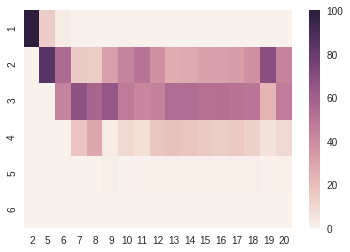

In [9]:
import seaborn as sns
%matplotlib inline

sns.heatmap(df)

Practcally, we can only brute force passwords at the first and second entropy levels and under 12 characters in length. This gives us a rough idea of what kind of success we could have. 

## Sources
https://apprize.info/python/hdf5/9.html

https://lethain.com/handling-very-large-csv-and-xml-files-in-python/